# How to Find the Optimal Location for a Virtual Fence Base Station

## Requirements

This Jupyter Notebook is intended to be run inside of ArcGIS Pro with the Spatial Analysis extension/license. It is not intended to be run in a Jupyter Notebook outside of ArcGIS Pro. If you are not familiar with the ArcGIS Pro ArcPy package, please view the [What is ArcPy?](https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/what-is-arcpy-.htm).

License Requirements:
    ArcGIS Pro >3.0
    Spatial Analyst Extension

You must have ArcGIS Pro installed on your computer to run this notebook, and you must have the Spatial Analyst extension enabled.

## How To Open This Notebook in ArcGIS Pro

1. Open ArcGIS Pro and create a new project
<div>
    <img src="../Images/ArcPro-New-Project-Screen.jpg" width="800"/>
</div>
2. Under the "Catalog" pane on the Map screen
<div>
    <img src="../Images/ArcPro-Map-Screen.jpg" width="800"/>
</div>
4. Click on the "Notebooks" folder under the

5. Double-click on the main.ipynb Jupyter Notebook
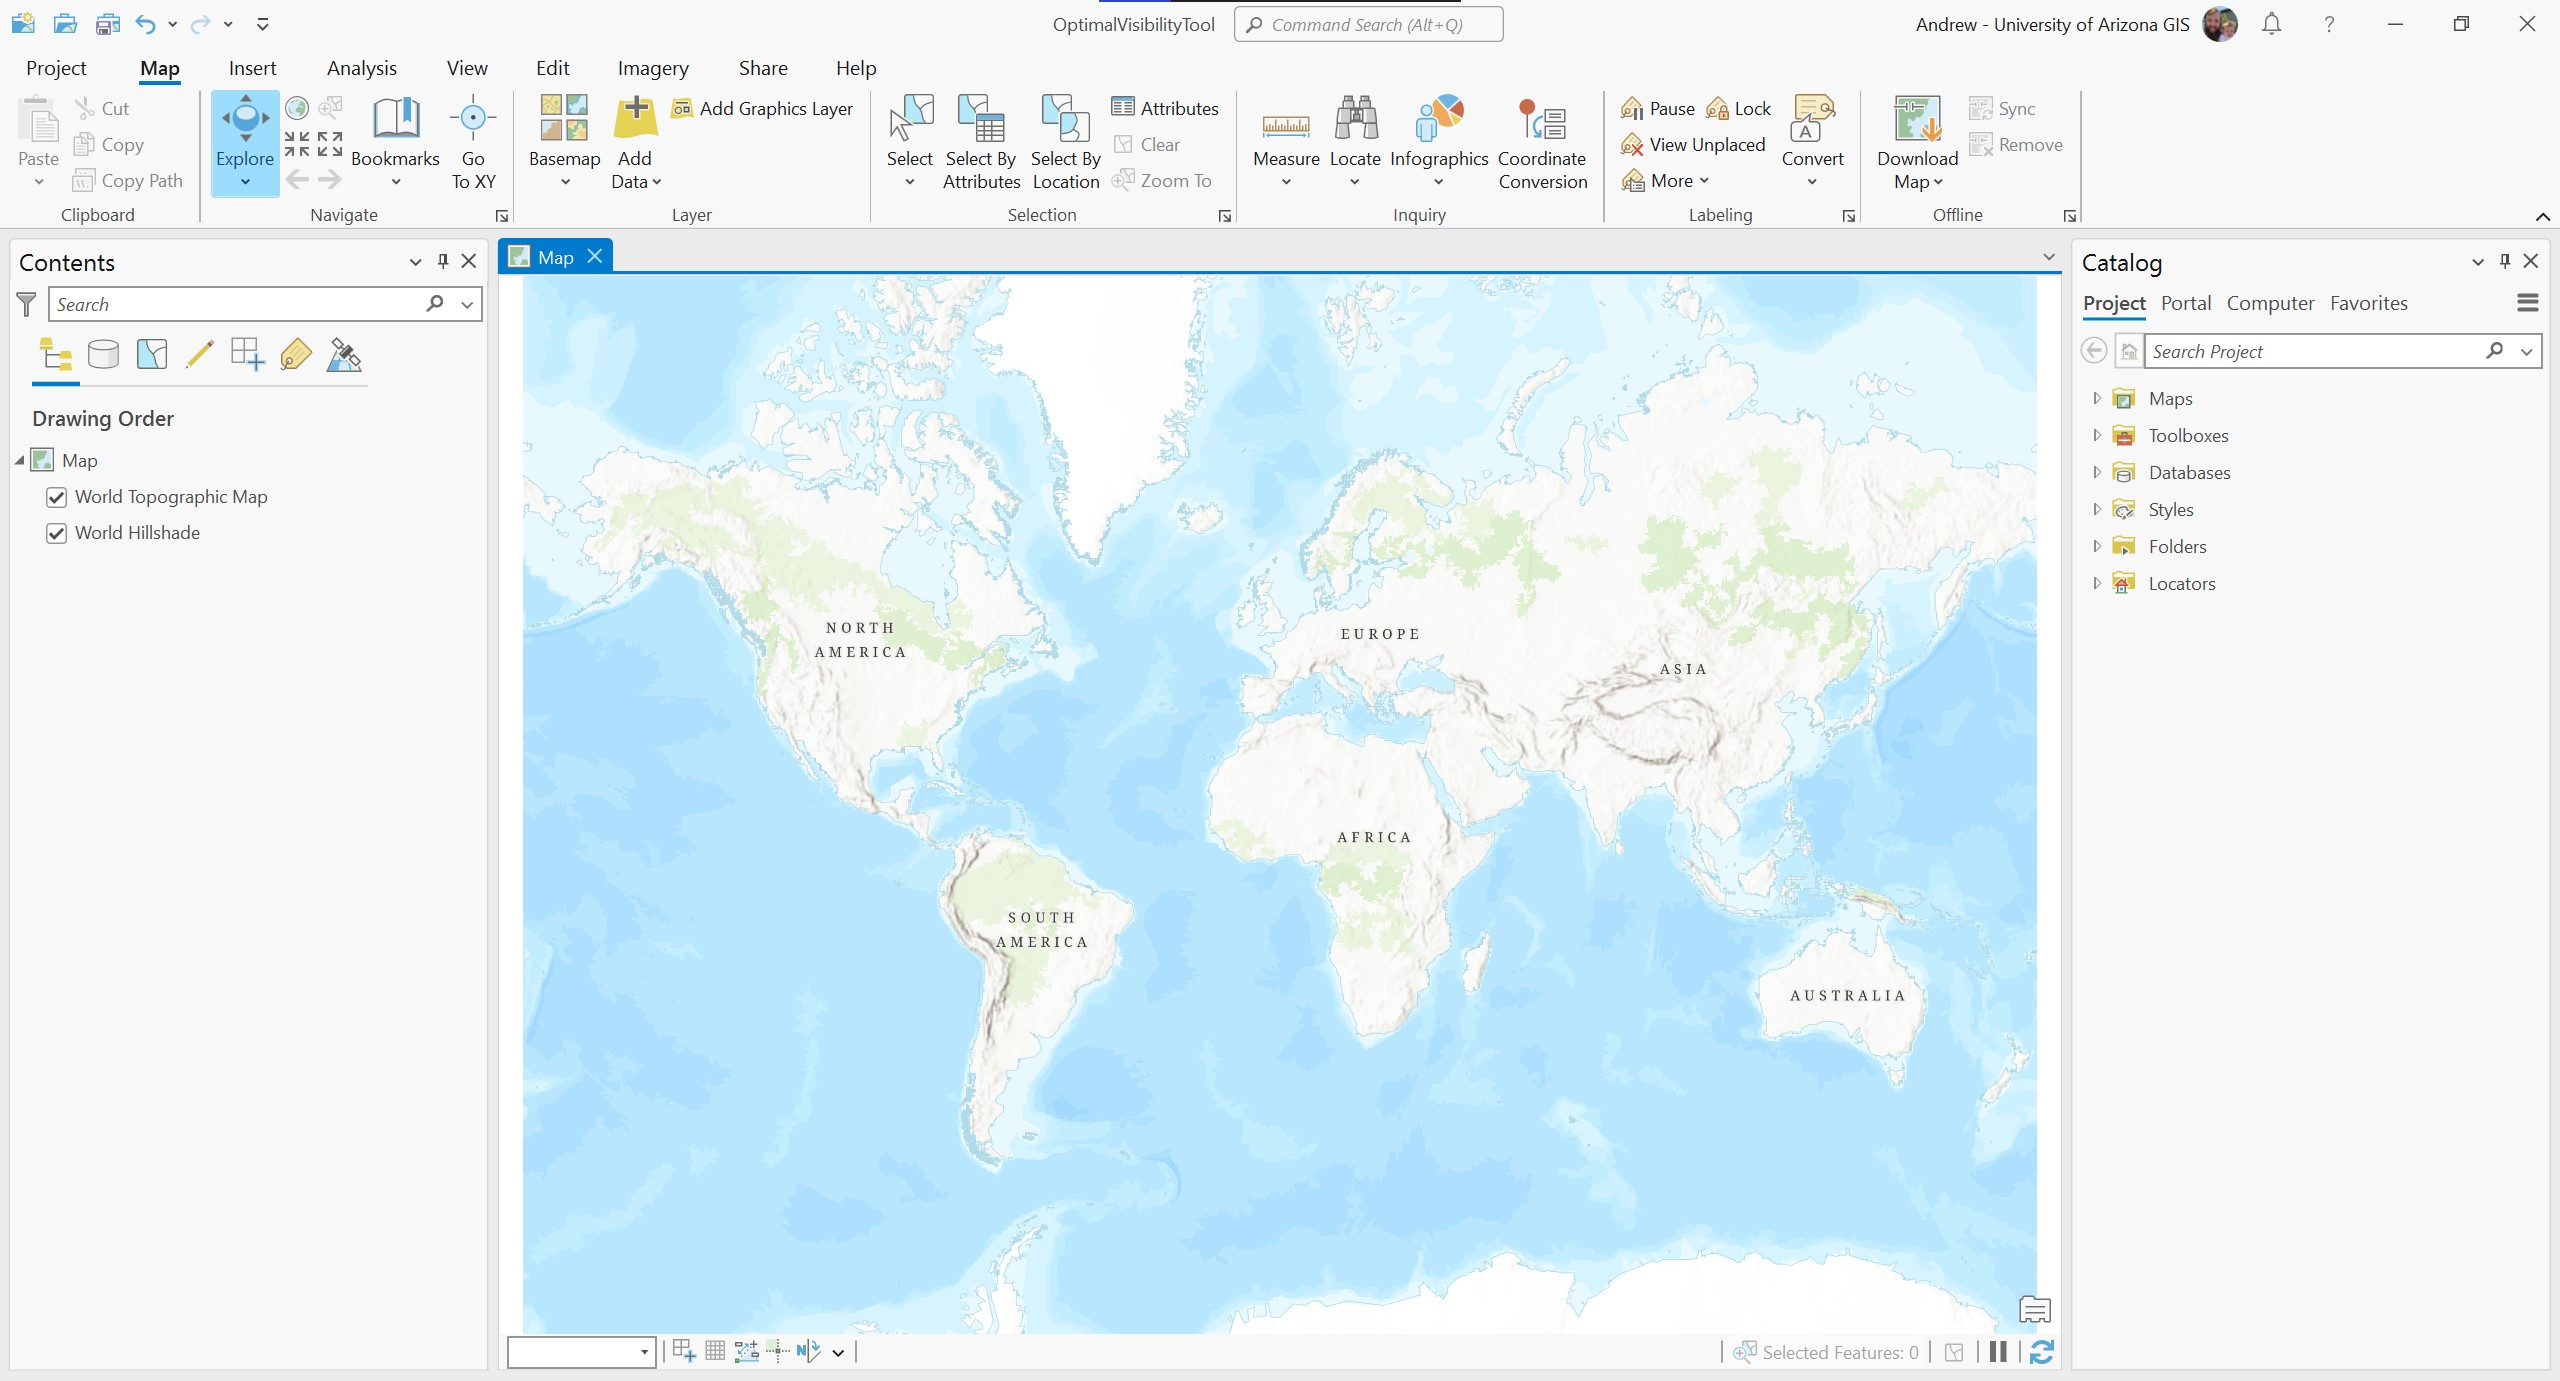

In [ ]:
# import required packages
import arcpy
from arcpy import env
from arcpy.sa import *
import csv
import pandas as pd
import os

In [ ]:
# set workspace - replace this with your project workspace/geodatabase (view HowToFindFilePaths.md on github if confused!)
arcpy.env.workspace = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool"

In [20]:
# view your current working directory
os.getcwd()

'c:\\windows\\system32'

In [21]:
# change your working directory to your ArcGIS project folder
os.chdir(r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool")

In [22]:
# view your current working directory to see the new location
cwd = os.getcwd()
print(cwd)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool


In [23]:
# set location for raster files - replace this with any folder on your computer that can store your raster files.
# If you aren't sure, put it on your desktop.
rasterFolder = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters"
print(rasterFolder)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters


In [24]:
# set input raster DEM - replace this with your area's DEM! (view HowToFindYourDEM.md on github)
inputRaster = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters\SRER.tif"

In [25]:
# boundary polygon for the extent of our area - replace this with a shapefile of your area's boundaries!
# Look up US Parcel boundaries and download a shapefile of your area if you aren't sure
boundaryShapefile = r"C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Shapefiles\srerboundary\bounds.shp"

In [26]:
# allows arcpy to overwrite previous outputs
arcpy.env.overwriteOutput = True

In [27]:
# crop raster to boundary to create cropped raster
# TODO rename croppedRaster to cropped_raster
croppedRaster = ExtractByMask(inputRaster, boundaryShapefile)
# TODO the raster values are missing from the tif file
croppedRaster.save("Rasters/croppedRaster.tif")

In [28]:
# find local peaks within cropped raster.
# Default is 15 points, but set higher for more accuracy, and lower for faster processing time.
local_peaks = arcpy.defense.FindLocalPeaksValleys(
    croppedRaster, 
    "local_peaks", 
    "PEAKS", 
    5)

In [29]:
# Set the path for the new folder to hold visibility outputs relative to the current workspace.
# You can change the folder_name
# TODO rename "folder_name" to "output_folder_name"
folder_name = "visibility_output_5"
folder_path = os.path.join(rasterFolder, folder_name)
print(folder_path)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters\visibility_output_5


In [30]:
# Create the new folder if it doesn't already exist
if not os.path.isdir(folder_path):
    try:
        os.mkdir(folder_path)
    except OSError as error:
        print(error)

In [31]:
# select the name of the first field for the optimalVisibilityPoints
field = 'FID'

In [32]:
# list all object IDs from field = 'FID'
all_object_ids = [row[0] for row in arcpy.da.SearchCursor(local_peaks, field)]
print(all_object_ids)

[0, 1, 2, 3, 4]


In [33]:
# Find the object ID fieldname
objectidfield = arcpy.Describe(local_peaks).OIDFieldName
print(objectidfield)

FID


In [34]:
# looping through the points
for pointid in all_object_ids:  # For each object id in the object id list
    
    # create a where clause to select only the point with this object ID
    sql = "{0}={1}".format(
        arcpy.AddFieldDelimiters(
            datasource=local_peaks, 
            field=objectidfield), 
        pointid)
    
    # create a layer with only this point in it
    arcpy.MakeFeatureLayer_management(
        in_features=local_peaks, 
        out_layer=f"visibility_point_{pointid}",
        where_clause=sql)
    
    # run visibility analysis, with croppedRaster and visbilityRaster as observer
    # TODO I want to use the visibility from the uncropped raster
    # as the cropped raster may be missing mountains that may block the signal
    # observer height is set to 6 meters
    # you can change the observer_offset value to account for the height of the antenna if needed
    visibility_output = arcpy.sa.Visibility(croppedRaster,
                                 f"visibility_point_{pointid}",
                                 analysis_type="OBSERVERS", 
                                 nonvisible_cell_value="NODATA", 
                                 observer_offset=6)
    
    # name the objects using object ID
    # I named them visibility_analysis_1.tif, visibility_analysis_2.tif etc...
    output_raster_name = os.path.join(folder_path,
                                      "visiblity_analysis_{0}.tif".format(pointid))
    # save output raster with name called in above
    # TODO rename this variable to "last_visibility_output"
    visibility_output.save(output_raster_name)

In [35]:
# Use the ListRasters function to create a list of rasters in the folder
arcpy.env.workspace = os.path.join(rasterFolder, folder_name)
print(arcpy.env.workspace)
rasters = arcpy.ListRasters()
print(rasters)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters\visibility_output_5
['visiblity_analysis_0.tif', 'visiblity_analysis_1.tif', 'visiblity_analysis_2.tif', 'visiblity_analysis_3.tif', 'visiblity_analysis_4.tif']


In [36]:
# load the visibility analysis rasters into ArcGIS for visual comparison
aprx = arcpy.mp.ArcGISProject('CURRENT')
for raster in rasters:
    raster_layer = arcpy.MakeRasterLayer_management(raster, f"{raster}")

In [37]:
# intialize variables to keep track of the maximum count value and the name of the raster with the maximum count value
max_count = -1
max_count_raster = ""

In [38]:
# save the CSV files in the "visibility_output_{}" folder
os.chdir(folder_path)
cwd = os.getcwd()
print(cwd)

C:\Users\andre\Dropbox\Dev\OptimalVisibilityTool\Rasters\visibility_output_5


In [39]:
# Iterate through the list of rasters
for raster in rasters:
    # Create a unique filename for the output dataframe
    output_filename = f"{raster}_table.csv"

    # Get the raster attribute table as a table view
    table_view_name = f"{raster}_view"
    table_view = arcpy.MakeTableView_management(raster, table_view_name)

    # Get the Count value from each raster table using a SearchCursor
    count_field = "Count"
    with arcpy.da.SearchCursor(table_view, count_field) as cursor:
        count_values = [row[0] for row in cursor]

    # Find the maximum count value
    count_max = max(count_values)

    # Check if the Count value is greater than the current maximum count value
    if count_max > max_count:
        # If so, update the maximum count value and the name of the raster with the maximum count value
        max_count = count_max
        max_count_raster = raster

    # Convert the table view to a Pandas dataframe
    dataframe = pd.DataFrame.from_records(arcpy.da.TableToNumPyArray(table_view, count_field))

    # Save the dataframe to a file
    dataframe.to_csv(output_filename, index=False)

    # Print a message indicating the dataframe has been saved
    print(f"{output_filename} saved successfully.")

visiblity_analysis_0.tif_table.csv saved successfully.
visiblity_analysis_1.tif_table.csv saved successfully.
visiblity_analysis_2.tif_table.csv saved successfully.
visiblity_analysis_3.tif_table.csv saved successfully.
visiblity_analysis_4.tif_table.csv saved successfully.


In [40]:
# Print the name of the raster with the maximum count value
# The count value represents the number of raster cells that the point has visibility of
print(f"Raster with the highest visibility is {max_count_raster} with a count of {max_count}")
# You can find this raster in your specified output folder.
# The raster number corresponds with the point number within the "pointsSelection" feature class
# View the 'HowToInterpretResults.md' in the tutorials folder on github for more information

Raster with the highest visibility is visiblity_analysis_2.tif with a count of 2118807.0
